# Toxic comment classification from A to Z

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_union

from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import Callback, EarlyStopping
from nltk import word_tokenize

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# read data to dataframe
df_trn = pd.read_csv('../input/train.csv')
df_tst = pd.read_csv('../input/test.csv')

print('trn shape {} rows, {} cols'.format(*df_trn.shape))
print('tst shape {} rows, {} cols'.format(*df_tst.shape))

trn shape 159571 rows, 8 cols
tst shape 153164 rows, 2 cols


In [4]:
X_trn = df_trn["comment_text"].fillna("fillna").values
y_trn = df_trn[[
    "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"
]].values
X_tst = df_tst["comment_text"].fillna(" ").values

max_features = 50000
maxlen = 100
embed_size = 300

print('tokenizer.fit_on_texts')
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_trn) + list(X_tst))
print('tokenizer.texts_to_sequences(X_trn)')
X_trn = tokenizer.texts_to_sequences(X_trn)
print('tokenizer.texts_to_sequences(X_tst)')
X_tst = tokenizer.texts_to_sequences(X_tst)
print('sequence.pad_sequences(X_trn, maxlen=maxlen)')
x_trn = sequence.pad_sequences(X_trn, maxlen=maxlen)
print('sequence.pad_sequences(X_tst, maxlen=maxlen)')
x_tst = sequence.pad_sequences(X_tst, maxlen=maxlen)

EMBEDDING_FILE = '../input/crawl-300d-2M.vec'
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
print('map embedding index')
embeddings_index = dict(
    get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in tqdm(word_index.items()):
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

tokenizer.fit_on_texts
tokenizer.texts_to_sequences(X_trn)
tokenizer.texts_to_sequences(X_tst)
sequence.pad_sequences(X_trn, maxlen=maxlen)
sequence.pad_sequences(X_tst, maxlen=maxlen)
map embedding index


100%|██████████| 394787/394787 [00:00<00:00, 519189.63it/s]


In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print(
                "\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch + 1, score))

In [17]:
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(6, activation="sigmoid")(conc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(
        loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [21]:
model = get_model()

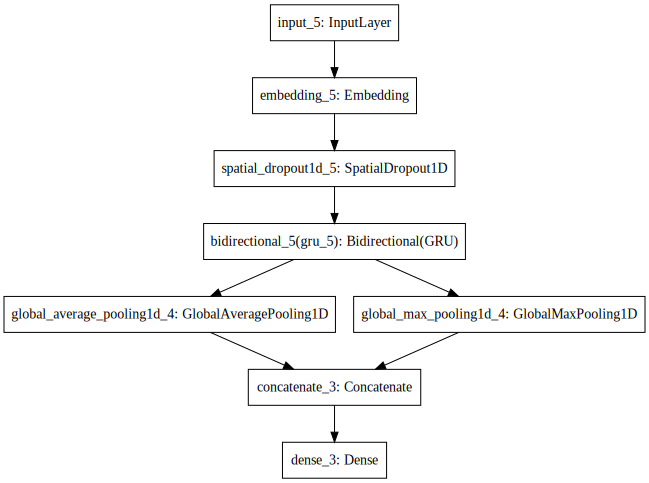

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 300)     9000000     input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 100, 300)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 100, 160)     182880      spatial_dropout1d_5[0][0]        
__________________________________________________________________________________________________
global_ave

9,184,806 parameters shoul be trained.

In [ ]:
batch_size = 32
epochs = 500

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)

In [ ]:
roc_auc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=(X_val, y_val),
                 callbacks=[roc_auc, EarlyStopping(patience=10)], verbose=2)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test, batch_size=1024)
submission = pd.read_csv('../input/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission.csv', index=False)